# Polystyrene Creep

Fit polystyrene creep at selectable temperature.

**Data:** examples/data/pyRheo/polystyrene/creep_ps130_data.csv (swap for other temps)


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

def load_tab_file(path):
    df = pd.read_csv(path, sep='	')
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df.iloc[:,0] = pd.to_numeric(df.iloc[:,0], errors='coerce')
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1], errors='coerce')
    df = df.dropna()
    return df
import arviz as az


INFO:2025-12-07 18:51:42,532:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load creep data (select temperature file)

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'polystyrene'
file = DATA_DIR / 'creep_ps130_data.csv'  # swap for other temps
df = load_tab_file(file)
t = df.iloc[:,0].to_numpy()
J = df.iloc[:,1].to_numpy()


## Fit creep models

In [4]:
gm = GeneralizedMaxwell(n_modes=2, modulus_type='tensile')  # Reduced modes for faster Bayesian
gm.fit(t, J, test_mode='creep', use_log_residuals=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, J)

fm = FractionalMaxwellModel()
fm.fit(t, J, test_mode='creep', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='creep')
fm_r2 = r2_complex(J, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})

Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.758852s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=25 | final_cost=5.478463e-07 | time=1.759s | final_gradient_norm=1.9702394933872192e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.781944s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=25 | final_cost=5.478463e-07 | time=0.782s | final_gradient_norm=1.9702394933872192e-06


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.751033s


Convergence: reason=`gtol` termination condition is satisfied. | iterations=22 | final_cost=4.927607e-07 | time=0.751s | final_gradient_norm=8.826545753484866e-07


Element minimization: reducing from 2 to 1 modes


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 1.986367s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=9.265395e+04 | time=1.986s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


{'gm_r2': 0.979266819909747, 'fm_r2': -0.6493061250932333}


## Plot creep fits

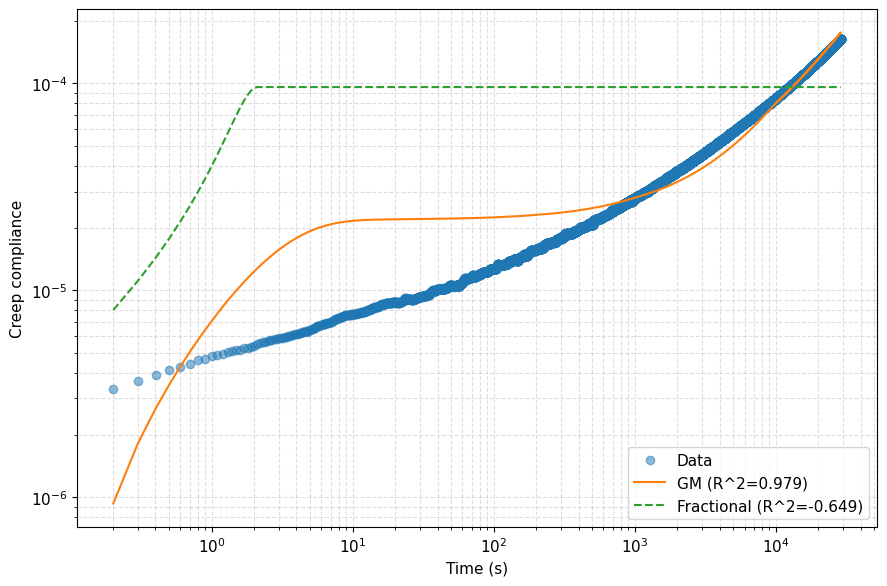

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(t, J, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'GM (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Creep compliance')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.269856s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=18 | final_cost=3.665419e-06 | time=0.270s | final_gradient_norm=0.004516178398135474


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


[WARNING] Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Inner optimization loop hit iteration limit | {'inner_iterations': 100, 'actual_reduction': -1}


Timer: optimization took 1.326083s


Convergence: reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=9.265395e+04 | time=1.326s | final_gradient_norm=nan


NLSQ hit inner iteration limit; retrying with SciPy least_squares for stability.


Model ranking (R²): [('gm', 0.846), ('fm', -1712609185947976.5)]


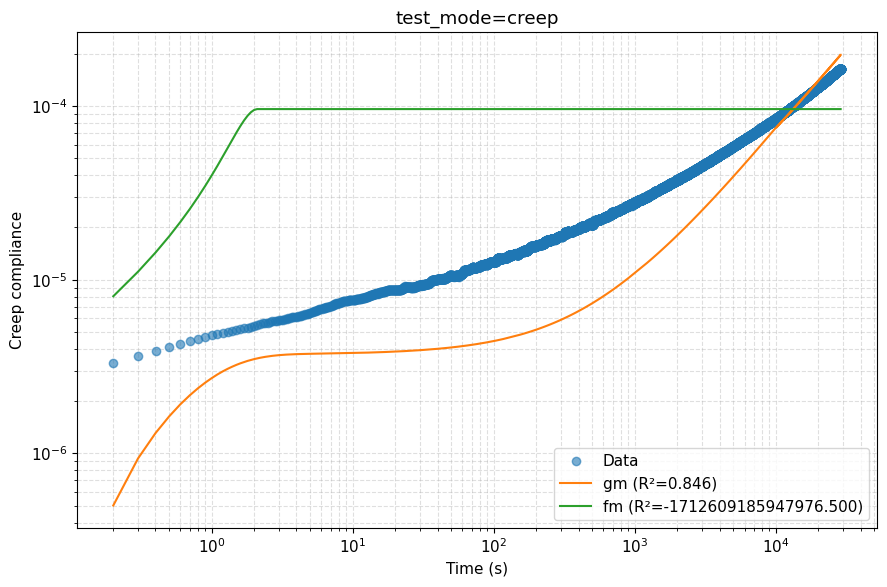

  0%|          | 0/1500 [00:00<?, ?it/s]

warmup:   0%|          | 1/1500 [00:00<15:47,  1.58it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 15/1500 [00:00<00:54, 27.01it/s, 52 steps of size 3.45e-07. acc. prob=0.43]

warmup:   2%|▏         | 25/1500 [00:00<00:35, 41.94it/s, 13 steps of size 9.36e-07. acc. prob=0.57]

warmup:   2%|▏         | 34/1500 [00:00<00:28, 51.80it/s, 15 steps of size 1.31e-06. acc. prob=0.62]

warmup:   3%|▎         | 45/1500 [00:01<00:23, 62.89it/s, 36 steps of size 2.41e-07. acc. prob=0.64]

warmup:   4%|▎         | 54/1500 [00:01<00:30, 46.77it/s, 19 steps of size 1.15e-06. acc. prob=0.67]

warmup:   4%|▍         | 63/1500 [00:01<00:27, 53.07it/s, 28 steps of size 4.29e-07. acc. prob=0.68]

warmup:   5%|▍         | 71/1500 [00:01<00:27, 51.36it/s, 35 steps of size 1.86e-07. acc. prob=0.68]

warmup:   5%|▌         | 78/1500 [00:01<00:31, 45.80it/s, 6 steps of size 7.67e-07. acc. prob=0.70] 

warmup:   6%|▌         | 90/1500 [00:01<00:23, 60.39it/s, 5 steps of size 1.80e-07. acc. prob=0.70]

warmup:   7%|▋         | 98/1500 [00:02<00:26, 52.28it/s, 9 steps of size 4.48e-07. acc. prob=0.71]

warmup:   7%|▋         | 105/1500 [00:03<01:31, 15.22it/s, 35 steps of size 1.19e-05. acc. prob=0.71]

warmup:   7%|▋         | 110/1500 [00:03<01:19, 17.41it/s, 7 steps of size 8.71e-05. acc. prob=0.72] 

warmup:   8%|▊         | 119/1500 [00:03<00:57, 23.86it/s, 33 steps of size 7.50e-06. acc. prob=0.72]

warmup:   8%|▊         | 125/1500 [00:04<00:58, 23.63it/s, 36 steps of size 1.31e-05. acc. prob=0.73]

warmup:   9%|▊         | 130/1500 [00:04<01:00, 22.82it/s, 9 steps of size 3.68e-05. acc. prob=0.73] 

warmup:   9%|▉         | 137/1500 [00:04<00:48, 28.24it/s, 21 steps of size 4.51e-05. acc. prob=0.74]

warmup:  10%|▉         | 144/1500 [00:04<00:39, 34.53it/s, 4 steps of size 5.08e-05. acc. prob=0.74] 

warmup:  10%|█         | 155/1500 [00:04<00:28, 47.18it/s, 9 steps of size 2.30e-06. acc. prob=0.73]

warmup:  11%|█         | 162/1500 [00:05<00:51, 26.12it/s, 20 steps of size 1.54e-05. acc. prob=0.74]

warmup:  11%|█         | 167/1500 [00:05<00:45, 29.10it/s, 3 steps of size 2.93e-05. acc. prob=0.74] 

warmup:  12%|█▏        | 173/1500 [00:05<00:39, 33.45it/s, 20 steps of size 2.09e-05. acc. prob=0.74]

warmup:  12%|█▏        | 186/1500 [00:05<00:27, 47.58it/s, 36 steps of size 1.38e-06. acc. prob=0.74]

warmup:  13%|█▎        | 193/1500 [00:06<00:44, 29.34it/s, 42 steps of size 1.21e-05. acc. prob=0.75]

warmup:  13%|█▎        | 198/1500 [00:06<00:55, 23.59it/s, 24 steps of size 2.65e-05. acc. prob=0.75]

warmup:  14%|█▍        | 207/1500 [00:06<00:43, 29.81it/s, 51 steps of size 3.12e-05. acc. prob=0.75]

warmup:  14%|█▍        | 212/1500 [00:06<00:41, 31.05it/s, 17 steps of size 3.27e-05. acc. prob=0.76]

warmup:  14%|█▍        | 217/1500 [00:06<00:42, 30.44it/s, 52 steps of size 3.70e-05. acc. prob=0.76]

warmup:  15%|█▍        | 221/1500 [00:07<00:44, 28.89it/s, 60 steps of size 6.46e-05. acc. prob=0.76]

warmup:  15%|█▌        | 228/1500 [00:07<00:40, 31.33it/s, 89 steps of size 6.44e-06. acc. prob=0.76]

warmup:  15%|█▌        | 232/1500 [00:07<00:53, 23.86it/s, 75 steps of size 1.37e-05. acc. prob=0.76]

warmup:  16%|█▌        | 236/1500 [00:07<00:49, 25.35it/s, 40 steps of size 3.91e-05. acc. prob=0.76]

warmup:  16%|█▋        | 245/1500 [00:07<00:35, 35.62it/s, 35 steps of size 7.82e-07. acc. prob=0.75]

warmup:  17%|█▋        | 250/1500 [00:08<00:50, 24.96it/s, 18 steps of size 2.52e-06. acc. prob=0.76]

warmup:  17%|█▋        | 257/1500 [00:08<00:39, 31.85it/s, 2 steps of size 2.94e-05. acc. prob=0.76] 

warmup:  18%|█▊        | 265/1500 [00:08<00:34, 35.79it/s, 132 steps of size 7.30e-07. acc. prob=0.76]

warmup:  18%|█▊        | 270/1500 [00:09<01:08, 17.94it/s, 66 steps of size 8.12e-06. acc. prob=0.76] 

warmup:  18%|█▊        | 274/1500 [00:09<01:00, 20.33it/s, 17 steps of size 1.74e-05. acc. prob=0.76]

warmup:  19%|█▊        | 278/1500 [00:09<00:55, 22.18it/s, 14 steps of size 4.15e-05. acc. prob=0.76]

warmup:  19%|█▉        | 282/1500 [00:09<00:50, 24.32it/s, 22 steps of size 3.35e-05. acc. prob=0.76]

warmup:  19%|█▉        | 286/1500 [00:09<00:47, 25.39it/s, 19 steps of size 6.97e-05. acc. prob=0.76]

warmup:  20%|█▉        | 293/1500 [00:09<00:38, 31.19it/s, 51 steps of size 7.79e-05. acc. prob=0.76]

warmup:  20%|█▉        | 298/1500 [00:09<00:38, 31.57it/s, 63 steps of size 2.03e-05. acc. prob=0.76]

warmup:  20%|██        | 303/1500 [00:10<00:35, 33.71it/s, 33 steps of size 4.23e-05. acc. prob=0.77]

warmup:  21%|██        | 311/1500 [00:10<00:28, 41.06it/s, 64 steps of size 8.83e-06. acc. prob=0.76]

warmup:  21%|██        | 316/1500 [00:10<00:42, 27.77it/s, 41 steps of size 2.20e-05. acc. prob=0.77]

warmup:  21%|██▏       | 320/1500 [00:10<00:45, 25.75it/s, 13 steps of size 1.97e-05. acc. prob=0.77]

warmup:  22%|██▏       | 324/1500 [00:10<00:45, 25.71it/s, 5 steps of size 2.36e-05. acc. prob=0.77] 

warmup:  22%|██▏       | 330/1500 [00:11<00:36, 31.91it/s, 32 steps of size 5.39e-05. acc. prob=0.77]

warmup:  22%|██▏       | 337/1500 [00:11<00:29, 39.08it/s, 19 steps of size 7.13e-05. acc. prob=0.77]

warmup:  23%|██▎       | 342/1500 [00:11<00:32, 35.34it/s, 58 steps of size 5.00e-05. acc. prob=0.77]

warmup:  23%|██▎       | 347/1500 [00:11<00:31, 36.87it/s, 4 steps of size 9.05e-05. acc. prob=0.77] 

warmup:  24%|██▍       | 357/1500 [00:11<00:23, 47.98it/s, 34 steps of size 2.34e-05. acc. prob=0.77]

warmup:  24%|██▍       | 363/1500 [00:11<00:34, 32.86it/s, 14 steps of size 5.48e-05. acc. prob=0.77]

warmup:  25%|██▍       | 368/1500 [00:12<00:31, 35.49it/s, 19 steps of size 5.28e-05. acc. prob=0.77]

warmup:  25%|██▍       | 373/1500 [00:12<00:30, 36.46it/s, 19 steps of size 6.89e-05. acc. prob=0.77]

warmup:  25%|██▌       | 378/1500 [00:12<00:29, 37.45it/s, 21 steps of size 8.23e-05. acc. prob=0.77]

warmup:  26%|██▌       | 383/1500 [00:12<00:34, 32.50it/s, 28 steps of size 4.27e-05. acc. prob=0.77]

warmup:  26%|██▌       | 389/1500 [00:12<00:30, 36.18it/s, 31 steps of size 7.09e-05. acc. prob=0.77]

warmup:  26%|██▋       | 396/1500 [00:12<00:25, 43.17it/s, 67 steps of size 1.17e-05. acc. prob=0.77]

warmup:  27%|██▋       | 406/1500 [00:12<00:22, 49.62it/s, 78 steps of size 2.95e-06. acc. prob=0.77]

warmup:  27%|██▋       | 412/1500 [00:13<00:48, 22.55it/s, 6 steps of size 1.03e-05. acc. prob=0.77] 

warmup:  28%|██▊       | 416/1500 [00:13<00:43, 24.67it/s, 7 steps of size 1.79e-05. acc. prob=0.77]

warmup:  28%|██▊       | 420/1500 [00:13<00:41, 26.17it/s, 31 steps of size 4.12e-05. acc. prob=0.78]

warmup:  29%|██▊       | 428/1500 [00:13<00:31, 34.39it/s, 21 steps of size 3.48e-05. acc. prob=0.78]

warmup:  29%|██▉       | 440/1500 [00:13<00:20, 50.68it/s, 2 steps of size 1.69e-06. acc. prob=0.77] 

warmup:  30%|██▉       | 447/1500 [00:15<01:16, 13.80it/s, 649 steps of size 1.45e-06. acc. prob=0.77]

warmup:  30%|███       | 452/1500 [00:19<04:01,  4.33it/s, 128 steps of size 2.01e-05. acc. prob=0.77]

warmup:  30%|███       | 456/1500 [00:19<03:21,  5.18it/s, 21 steps of size 1.56e-04. acc. prob=0.77] 

warmup:  31%|███       | 460/1500 [00:19<02:42,  6.39it/s, 8 steps of size 5.48e-05. acc. prob=0.77] 

warmup:  31%|███       | 464/1500 [00:19<02:11,  7.85it/s, 14 steps of size 3.32e-05. acc. prob=0.77]

warmup:  31%|███       | 468/1500 [00:20<02:04,  8.27it/s, 127 steps of size 1.86e-05. acc. prob=0.77]

warmup:  31%|███▏      | 471/1500 [00:20<01:51,  9.24it/s, 20 steps of size 3.50e-05. acc. prob=0.77] 

warmup:  32%|███▏      | 474/1500 [00:20<01:35, 10.70it/s, 63 steps of size 1.88e-05. acc. prob=0.77]

warmup:  32%|███▏      | 477/1500 [00:20<01:32, 11.01it/s, 34 steps of size 2.00e-05. acc. prob=0.77]

warmup:  32%|███▏      | 480/1500 [00:20<01:22, 12.37it/s, 84 steps of size 1.46e-05. acc. prob=0.77]

warmup:  32%|███▏      | 482/1500 [00:21<01:47,  9.43it/s, 133 steps of size 3.97e-05. acc. prob=0.77]

warmup:  32%|███▏      | 484/1500 [00:21<02:01,  8.39it/s, 235 steps of size 2.56e-05. acc. prob=0.77]

warmup:  32%|███▏      | 486/1500 [00:21<01:58,  8.56it/s, 116 steps of size 1.97e-05. acc. prob=0.77]

warmup:  33%|███▎      | 489/1500 [00:22<01:34, 10.67it/s, 49 steps of size 2.06e-05. acc. prob=0.77] 

warmup:  33%|███▎      | 491/1500 [00:22<01:35, 10.56it/s, 98 steps of size 4.21e-05. acc. prob=0.77]

warmup:  33%|███▎      | 494/1500 [00:22<01:21, 12.35it/s, 63 steps of size 4.05e-05. acc. prob=0.77]

warmup:  33%|███▎      | 496/1500 [00:22<01:18, 12.84it/s, 63 steps of size 7.27e-05. acc. prob=0.78]

warmup:  33%|███▎      | 500/1500 [00:22<00:57, 17.49it/s, 14 steps of size 3.75e-05. acc. prob=0.78]

sample:  34%|███▎      | 503/1500 [00:22<00:55, 17.98it/s, 45 steps of size 3.75e-05. acc. prob=0.85]

sample:  34%|███▎      | 506/1500 [00:23<00:56, 17.67it/s, 65 steps of size 3.75e-05. acc. prob=0.85]

sample:  34%|███▍      | 508/1500 [00:23<00:58, 17.09it/s, 52 steps of size 3.75e-05. acc. prob=0.87]

sample:  34%|███▍      | 511/1500 [00:23<00:49, 19.79it/s, 63 steps of size 3.75e-05. acc. prob=0.87]

sample:  34%|███▍      | 514/1500 [00:23<00:51, 19.19it/s, 14 steps of size 3.75e-05. acc. prob=0.86]

sample:  35%|███▍      | 521/1500 [00:23<00:32, 30.00it/s, 11 steps of size 3.75e-05. acc. prob=0.86]

sample:  35%|███▌      | 525/1500 [00:23<00:34, 28.24it/s, 19 steps of size 3.75e-05. acc. prob=0.84]

sample:  35%|███▌      | 529/1500 [00:23<00:38, 25.11it/s, 53 steps of size 3.75e-05. acc. prob=0.85]

sample:  35%|███▌      | 532/1500 [00:24<00:44, 21.63it/s, 48 steps of size 3.75e-05. acc. prob=0.84]

sample:  36%|███▌      | 535/1500 [00:24<00:44, 21.65it/s, 57 steps of size 3.75e-05. acc. prob=0.85]

sample:  36%|███▌      | 539/1500 [00:24<00:41, 23.43it/s, 40 steps of size 3.75e-05. acc. prob=0.85]

sample:  36%|███▌      | 542/1500 [00:24<00:45, 21.22it/s, 68 steps of size 3.75e-05. acc. prob=0.84]

sample:  36%|███▋      | 545/1500 [00:24<00:43, 21.92it/s, 18 steps of size 3.75e-05. acc. prob=0.84]

sample:  37%|███▋      | 551/1500 [00:24<00:33, 28.30it/s, 40 steps of size 3.75e-05. acc. prob=0.85]

sample:  37%|███▋      | 554/1500 [00:24<00:33, 27.83it/s, 41 steps of size 3.75e-05. acc. prob=0.85]

sample:  37%|███▋      | 561/1500 [00:25<00:28, 32.49it/s, 71 steps of size 3.75e-05. acc. prob=0.84]

sample:  38%|███▊      | 565/1500 [00:25<00:38, 24.44it/s, 44 steps of size 3.75e-05. acc. prob=0.85]

sample:  38%|███▊      | 568/1500 [00:25<00:39, 23.58it/s, 43 steps of size 3.75e-05. acc. prob=0.85]

sample:  38%|███▊      | 571/1500 [00:25<00:39, 23.52it/s, 20 steps of size 3.75e-05. acc. prob=0.85]

sample:  39%|███▊      | 579/1500 [00:25<00:28, 32.17it/s, 45 steps of size 3.75e-05. acc. prob=0.85]

sample:  39%|███▉      | 583/1500 [00:25<00:28, 32.30it/s, 25 steps of size 3.75e-05. acc. prob=0.85]

sample:  39%|███▉      | 587/1500 [00:26<00:34, 26.67it/s, 63 steps of size 3.75e-05. acc. prob=0.86]

sample:  39%|███▉      | 590/1500 [00:26<00:39, 23.20it/s, 18 steps of size 3.75e-05. acc. prob=0.86]

sample:  40%|███▉      | 598/1500 [00:26<00:26, 33.86it/s, 10 steps of size 3.75e-05. acc. prob=0.86]

sample:  40%|████      | 606/1500 [00:26<00:20, 43.37it/s, 7 steps of size 3.75e-05. acc. prob=0.86] 

sample:  41%|████      | 612/1500 [00:26<00:19, 46.03it/s, 11 steps of size 3.75e-05. acc. prob=0.86]

sample:  41%|████      | 618/1500 [00:26<00:25, 33.93it/s, 63 steps of size 3.75e-05. acc. prob=0.86]

sample:  42%|████▏     | 623/1500 [00:27<00:27, 31.89it/s, 26 steps of size 3.75e-05. acc. prob=0.86]

sample:  42%|████▏     | 631/1500 [00:27<00:22, 39.05it/s, 37 steps of size 3.75e-05. acc. prob=0.85]

sample:  42%|████▏     | 636/1500 [00:27<00:30, 28.36it/s, 5 steps of size 3.75e-05. acc. prob=0.85] 

sample:  43%|████▎     | 640/1500 [00:27<00:33, 25.65it/s, 37 steps of size 3.75e-05. acc. prob=0.85]

sample:  43%|████▎     | 644/1500 [00:27<00:32, 26.17it/s, 33 steps of size 3.75e-05. acc. prob=0.85]

sample:  43%|████▎     | 648/1500 [00:28<00:30, 27.97it/s, 32 steps of size 3.75e-05. acc. prob=0.85]

sample:  43%|████▎     | 652/1500 [00:28<00:32, 26.20it/s, 117 steps of size 3.75e-05. acc. prob=0.85]

sample:  44%|████▎     | 655/1500 [00:28<00:37, 22.67it/s, 53 steps of size 3.75e-05. acc. prob=0.85] 

sample:  44%|████▍     | 658/1500 [00:28<00:41, 20.34it/s, 59 steps of size 3.75e-05. acc. prob=0.85]

sample:  44%|████▍     | 663/1500 [00:28<00:32, 25.83it/s, 14 steps of size 3.75e-05. acc. prob=0.85]

sample:  44%|████▍     | 666/1500 [00:28<00:34, 24.44it/s, 71 steps of size 3.75e-05. acc. prob=0.85]

sample:  45%|████▍     | 669/1500 [00:28<00:32, 25.35it/s, 9 steps of size 3.75e-05. acc. prob=0.86] 

sample:  45%|████▍     | 673/1500 [00:29<00:29, 27.74it/s, 68 steps of size 3.75e-05. acc. prob=0.85]

sample:  45%|████▌     | 676/1500 [00:29<00:33, 24.80it/s, 72 steps of size 3.75e-05. acc. prob=0.85]

sample:  45%|████▌     | 679/1500 [00:29<00:35, 22.86it/s, 32 steps of size 3.75e-05. acc. prob=0.85]

sample:  46%|████▌     | 685/1500 [00:29<00:27, 29.30it/s, 59 steps of size 3.75e-05. acc. prob=0.85]

sample:  46%|████▌     | 689/1500 [00:29<00:30, 26.35it/s, 77 steps of size 3.75e-05. acc. prob=0.85]

sample:  46%|████▌     | 693/1500 [00:29<00:29, 27.76it/s, 29 steps of size 3.75e-05. acc. prob=0.85]

sample:  47%|████▋     | 698/1500 [00:29<00:24, 32.55it/s, 42 steps of size 3.75e-05. acc. prob=0.85]

sample:  47%|████▋     | 702/1500 [00:30<00:23, 33.99it/s, 39 steps of size 3.75e-05. acc. prob=0.85]

sample:  47%|████▋     | 708/1500 [00:30<00:20, 37.79it/s, 38 steps of size 3.75e-05. acc. prob=0.85]

sample:  47%|████▋     | 712/1500 [00:30<00:25, 31.05it/s, 26 steps of size 3.75e-05. acc. prob=0.85]

sample:  48%|████▊     | 716/1500 [00:30<00:29, 27.00it/s, 66 steps of size 3.75e-05. acc. prob=0.85]

sample:  48%|████▊     | 719/1500 [00:30<00:36, 21.55it/s, 88 steps of size 3.75e-05. acc. prob=0.85]

sample:  48%|████▊     | 722/1500 [00:30<00:37, 20.94it/s, 45 steps of size 3.75e-05. acc. prob=0.86]

sample:  49%|████▊     | 728/1500 [00:31<00:27, 28.51it/s, 6 steps of size 3.75e-05. acc. prob=0.85] 

sample:  49%|████▉     | 742/1500 [00:31<00:14, 52.76it/s, 2 steps of size 3.75e-05. acc. prob=0.84]

sample:  50%|█████     | 750/1500 [00:31<00:13, 56.29it/s, 34 steps of size 3.75e-05. acc. prob=0.84]

sample:  50%|█████     | 757/1500 [00:31<00:13, 54.20it/s, 24 steps of size 3.75e-05. acc. prob=0.84]

sample:  51%|█████     | 764/1500 [00:31<00:22, 33.05it/s, 45 steps of size 3.75e-05. acc. prob=0.84]

sample:  51%|█████▏    | 769/1500 [00:32<00:24, 30.35it/s, 7 steps of size 3.75e-05. acc. prob=0.84] 

sample:  52%|█████▏    | 774/1500 [00:32<00:24, 29.95it/s, 58 steps of size 3.75e-05. acc. prob=0.84]

sample:  52%|█████▏    | 778/1500 [00:32<00:24, 29.13it/s, 48 steps of size 3.75e-05. acc. prob=0.84]

sample:  52%|█████▏    | 783/1500 [00:32<00:22, 32.20it/s, 53 steps of size 3.75e-05. acc. prob=0.84]

sample:  52%|█████▏    | 787/1500 [00:32<00:32, 21.99it/s, 28 steps of size 3.75e-05. acc. prob=0.84]

sample:  53%|█████▎    | 790/1500 [00:33<00:34, 20.38it/s, 72 steps of size 3.75e-05. acc. prob=0.84]

sample:  53%|█████▎    | 793/1500 [00:33<00:33, 21.34it/s, 46 steps of size 3.75e-05. acc. prob=0.84]

sample:  53%|█████▎    | 796/1500 [00:33<00:31, 22.59it/s, 52 steps of size 3.75e-05. acc. prob=0.84]

sample:  53%|█████▎    | 799/1500 [00:33<00:33, 20.79it/s, 45 steps of size 3.75e-05. acc. prob=0.85]

sample:  53%|█████▎    | 802/1500 [00:33<00:32, 21.29it/s, 32 steps of size 3.75e-05. acc. prob=0.85]

sample:  54%|█████▎    | 805/1500 [00:33<00:32, 21.69it/s, 22 steps of size 3.75e-05. acc. prob=0.85]

sample:  54%|█████▍    | 808/1500 [00:33<00:33, 20.64it/s, 80 steps of size 3.75e-05. acc. prob=0.85]

sample:  54%|█████▍    | 811/1500 [00:34<00:34, 20.19it/s, 72 steps of size 3.75e-05. acc. prob=0.85]

sample:  54%|█████▍    | 814/1500 [00:34<00:33, 20.22it/s, 68 steps of size 3.75e-05. acc. prob=0.85]

sample:  54%|█████▍    | 817/1500 [00:34<00:34, 19.62it/s, 65 steps of size 3.75e-05. acc. prob=0.84]

sample:  55%|█████▍    | 821/1500 [00:34<00:30, 22.33it/s, 33 steps of size 3.75e-05. acc. prob=0.84]

sample:  55%|█████▍    | 824/1500 [00:34<00:30, 21.88it/s, 49 steps of size 3.75e-05. acc. prob=0.84]

sample:  55%|█████▌    | 828/1500 [00:34<00:26, 25.74it/s, 34 steps of size 3.75e-05. acc. prob=0.84]

sample:  55%|█████▌    | 831/1500 [00:34<00:27, 24.68it/s, 81 steps of size 3.75e-05. acc. prob=0.84]

sample:  56%|█████▌    | 834/1500 [00:35<00:29, 22.69it/s, 81 steps of size 3.75e-05. acc. prob=0.84]

sample:  56%|█████▌    | 837/1500 [00:35<00:34, 19.07it/s, 53 steps of size 3.75e-05. acc. prob=0.85]

sample:  56%|█████▌    | 840/1500 [00:35<00:33, 19.52it/s, 29 steps of size 3.75e-05. acc. prob=0.84]

sample:  56%|█████▌    | 843/1500 [00:35<00:41, 15.82it/s, 71 steps of size 3.75e-05. acc. prob=0.84]

sample:  56%|█████▋    | 847/1500 [00:35<00:32, 20.10it/s, 20 steps of size 3.75e-05. acc. prob=0.85]

sample:  57%|█████▋    | 857/1500 [00:35<00:18, 35.27it/s, 33 steps of size 3.75e-05. acc. prob=0.84]

sample:  57%|█████▋    | 862/1500 [00:36<00:17, 35.81it/s, 16 steps of size 3.75e-05. acc. prob=0.84]

sample:  58%|█████▊    | 867/1500 [00:36<00:24, 26.12it/s, 102 steps of size 3.75e-05. acc. prob=0.84]

sample:  58%|█████▊    | 871/1500 [00:36<00:32, 19.56it/s, 90 steps of size 3.75e-05. acc. prob=0.84] 

sample:  58%|█████▊    | 874/1500 [00:37<00:38, 16.06it/s, 54 steps of size 3.75e-05. acc. prob=0.84]

sample:  58%|█████▊    | 877/1500 [00:37<00:39, 15.73it/s, 48 steps of size 3.75e-05. acc. prob=0.84]

sample:  59%|█████▊    | 879/1500 [00:37<00:38, 16.33it/s, 21 steps of size 3.75e-05. acc. prob=0.84]

sample:  59%|█████▊    | 881/1500 [00:37<00:39, 15.71it/s, 82 steps of size 3.75e-05. acc. prob=0.84]

sample:  59%|█████▉    | 883/1500 [00:37<00:49, 12.42it/s, 127 steps of size 3.75e-05. acc. prob=0.84]

sample:  59%|█████▉    | 886/1500 [00:37<00:45, 13.39it/s, 84 steps of size 3.75e-05. acc. prob=0.84] 

sample:  59%|█████▉    | 889/1500 [00:38<00:38, 15.75it/s, 24 steps of size 3.75e-05. acc. prob=0.84]

sample:  60%|█████▉    | 895/1500 [00:38<00:25, 23.70it/s, 18 steps of size 3.75e-05. acc. prob=0.84]

sample:  60%|█████▉    | 898/1500 [00:38<00:28, 21.07it/s, 43 steps of size 3.75e-05. acc. prob=0.84]

sample:  60%|██████    | 901/1500 [00:38<00:26, 22.49it/s, 46 steps of size 3.75e-05. acc. prob=0.84]

sample:  61%|██████    | 909/1500 [00:38<00:16, 34.87it/s, 15 steps of size 3.75e-05. acc. prob=0.84]

sample:  61%|██████    | 914/1500 [00:38<00:16, 35.16it/s, 14 steps of size 3.75e-05. acc. prob=0.84]

sample:  61%|██████    | 918/1500 [00:38<00:18, 31.74it/s, 37 steps of size 3.75e-05. acc. prob=0.84]

sample:  61%|██████▏   | 922/1500 [00:39<00:24, 23.29it/s, 73 steps of size 3.75e-05. acc. prob=0.84]

sample:  62%|██████▏   | 925/1500 [00:39<00:24, 23.85it/s, 41 steps of size 3.75e-05. acc. prob=0.84]

sample:  62%|██████▏   | 928/1500 [00:39<00:26, 21.42it/s, 60 steps of size 3.75e-05. acc. prob=0.84]

sample:  62%|██████▏   | 931/1500 [00:39<00:30, 18.74it/s, 47 steps of size 3.75e-05. acc. prob=0.84]

sample:  62%|██████▏   | 934/1500 [00:39<00:28, 19.92it/s, 82 steps of size 3.75e-05. acc. prob=0.84]

sample:  63%|██████▎   | 938/1500 [00:39<00:24, 23.39it/s, 18 steps of size 3.75e-05. acc. prob=0.84]

sample:  63%|██████▎   | 944/1500 [00:40<00:18, 29.48it/s, 35 steps of size 3.75e-05. acc. prob=0.84]

sample:  63%|██████▎   | 948/1500 [00:40<00:23, 23.95it/s, 64 steps of size 3.75e-05. acc. prob=0.84]

sample:  63%|██████▎   | 951/1500 [00:40<00:23, 23.73it/s, 39 steps of size 3.75e-05. acc. prob=0.84]

sample:  64%|██████▎   | 954/1500 [00:40<00:23, 23.55it/s, 43 steps of size 3.75e-05. acc. prob=0.84]

sample:  64%|██████▍   | 957/1500 [00:40<00:24, 22.14it/s, 25 steps of size 3.75e-05. acc. prob=0.84]

sample:  64%|██████▍   | 960/1500 [00:40<00:24, 22.11it/s, 20 steps of size 3.75e-05. acc. prob=0.84]

sample:  64%|██████▍   | 963/1500 [00:41<00:27, 19.83it/s, 24 steps of size 3.75e-05. acc. prob=0.84]

sample:  65%|██████▍   | 968/1500 [00:41<00:22, 23.96it/s, 46 steps of size 3.75e-05. acc. prob=0.84]

sample:  65%|██████▍   | 971/1500 [00:41<00:22, 23.13it/s, 83 steps of size 3.75e-05. acc. prob=0.84]

sample:  65%|██████▍   | 974/1500 [00:41<00:21, 24.17it/s, 31 steps of size 3.75e-05. acc. prob=0.84]

sample:  65%|██████▌   | 977/1500 [00:41<00:22, 23.24it/s, 36 steps of size 3.75e-05. acc. prob=0.84]

sample:  65%|██████▌   | 980/1500 [00:41<00:22, 23.36it/s, 23 steps of size 3.75e-05. acc. prob=0.84]

sample:  66%|██████▌   | 985/1500 [00:41<00:19, 26.56it/s, 46 steps of size 3.75e-05. acc. prob=0.84]

sample:  66%|██████▌   | 990/1500 [00:41<00:17, 29.96it/s, 45 steps of size 3.75e-05. acc. prob=0.84]

sample:  66%|██████▋   | 995/1500 [00:42<00:16, 30.70it/s, 63 steps of size 3.75e-05. acc. prob=0.84]

sample:  67%|██████▋   | 999/1500 [00:42<00:18, 27.52it/s, 62 steps of size 3.75e-05. acc. prob=0.84]

sample:  67%|██████▋   | 1006/1500 [00:42<00:13, 35.68it/s, 14 steps of size 3.75e-05. acc. prob=0.84]

sample:  68%|██████▊   | 1021/1500 [00:42<00:07, 61.79it/s, 3 steps of size 3.75e-05. acc. prob=0.83] 

sample:  69%|██████▊   | 1029/1500 [00:42<00:07, 59.83it/s, 4 steps of size 3.75e-05. acc. prob=0.83]

sample:  69%|██████▉   | 1036/1500 [00:43<00:11, 39.66it/s, 73 steps of size 3.75e-05. acc. prob=0.83]

sample:  69%|██████▉   | 1042/1500 [00:43<00:15, 29.03it/s, 49 steps of size 3.75e-05. acc. prob=0.83]

sample:  70%|██████▉   | 1047/1500 [00:43<00:22, 20.07it/s, 59 steps of size 3.75e-05. acc. prob=0.83]

sample:  70%|███████   | 1051/1500 [00:44<00:28, 15.97it/s, 150 steps of size 3.75e-05. acc. prob=0.83]

sample:  70%|███████   | 1054/1500 [00:44<00:30, 14.62it/s, 111 steps of size 3.75e-05. acc. prob=0.83]

sample:  70%|███████   | 1057/1500 [00:44<00:29, 14.79it/s, 56 steps of size 3.75e-05. acc. prob=0.83] 

sample:  71%|███████   | 1059/1500 [00:44<00:29, 14.80it/s, 60 steps of size 3.75e-05. acc. prob=0.83]

sample:  71%|███████   | 1062/1500 [00:45<00:26, 16.51it/s, 59 steps of size 3.75e-05. acc. prob=0.83]

sample:  71%|███████   | 1064/1500 [00:45<00:25, 16.87it/s, 36 steps of size 3.75e-05. acc. prob=0.83]

sample:  71%|███████   | 1066/1500 [00:45<00:25, 17.11it/s, 40 steps of size 3.75e-05. acc. prob=0.83]

sample:  71%|███████   | 1068/1500 [00:45<00:28, 15.15it/s, 93 steps of size 3.75e-05. acc. prob=0.83]

sample:  71%|███████▏  | 1070/1500 [00:45<00:30, 14.16it/s, 94 steps of size 3.75e-05. acc. prob=0.83]

sample:  71%|███████▏  | 1072/1500 [00:45<00:32, 13.05it/s, 119 steps of size 3.75e-05. acc. prob=0.83]

sample:  72%|███████▏  | 1074/1500 [00:45<00:30, 13.99it/s, 59 steps of size 3.75e-05. acc. prob=0.83] 

sample:  72%|███████▏  | 1076/1500 [00:46<00:31, 13.62it/s, 55 steps of size 3.75e-05. acc. prob=0.83]

sample:  72%|███████▏  | 1078/1500 [00:46<00:32, 13.17it/s, 30 steps of size 3.75e-05. acc. prob=0.83]

sample:  72%|███████▏  | 1080/1500 [00:46<00:31, 13.43it/s, 53 steps of size 3.75e-05. acc. prob=0.83]

sample:  72%|███████▏  | 1082/1500 [00:46<00:30, 13.71it/s, 66 steps of size 3.75e-05. acc. prob=0.84]

sample:  72%|███████▏  | 1084/1500 [00:46<00:28, 14.53it/s, 24 steps of size 3.75e-05. acc. prob=0.84]

sample:  72%|███████▏  | 1086/1500 [00:46<00:29, 14.04it/s, 34 steps of size 3.75e-05. acc. prob=0.83]

sample:  73%|███████▎  | 1091/1500 [00:46<00:18, 22.05it/s, 22 steps of size 3.75e-05. acc. prob=0.84]

sample:  73%|███████▎  | 1097/1500 [00:47<00:12, 31.30it/s, 12 steps of size 3.75e-05. acc. prob=0.84]

sample:  74%|███████▎  | 1106/1500 [00:47<00:09, 40.71it/s, 57 steps of size 3.75e-05. acc. prob=0.84]

sample:  74%|███████▍  | 1111/1500 [00:47<00:12, 31.75it/s, 93 steps of size 3.75e-05. acc. prob=0.84]

sample:  74%|███████▍  | 1115/1500 [00:47<00:16, 22.80it/s, 123 steps of size 3.75e-05. acc. prob=0.84]

sample:  75%|███████▍  | 1118/1500 [00:47<00:17, 21.94it/s, 32 steps of size 3.75e-05. acc. prob=0.84] 

sample:  75%|███████▌  | 1125/1500 [00:48<00:12, 30.08it/s, 40 steps of size 3.75e-05. acc. prob=0.84]

sample:  75%|███████▌  | 1130/1500 [00:48<00:11, 33.52it/s, 11 steps of size 3.75e-05. acc. prob=0.84]

sample:  76%|███████▌  | 1137/1500 [00:48<00:09, 37.85it/s, 66 steps of size 3.75e-05. acc. prob=0.83]

sample:  76%|███████▌  | 1142/1500 [00:48<00:12, 28.99it/s, 35 steps of size 3.75e-05. acc. prob=0.84]

sample:  76%|███████▋  | 1146/1500 [00:48<00:12, 29.18it/s, 23 steps of size 3.75e-05. acc. prob=0.84]

sample:  77%|███████▋  | 1150/1500 [00:48<00:13, 25.27it/s, 38 steps of size 3.75e-05. acc. prob=0.84]

sample:  77%|███████▋  | 1153/1500 [00:49<00:14, 23.90it/s, 51 steps of size 3.75e-05. acc. prob=0.84]

sample:  77%|███████▋  | 1156/1500 [00:49<00:17, 20.07it/s, 67 steps of size 3.75e-05. acc. prob=0.84]

sample:  77%|███████▋  | 1159/1500 [00:49<00:20, 16.74it/s, 24 steps of size 3.75e-05. acc. prob=0.84]

sample:  77%|███████▋  | 1161/1500 [00:49<00:19, 17.00it/s, 44 steps of size 3.75e-05. acc. prob=0.84]

sample:  78%|███████▊  | 1164/1500 [00:49<00:17, 19.39it/s, 5 steps of size 3.75e-05. acc. prob=0.84] 

sample:  78%|███████▊  | 1169/1500 [00:49<00:12, 25.59it/s, 34 steps of size 3.75e-05. acc. prob=0.84]

sample:  78%|███████▊  | 1172/1500 [00:49<00:13, 25.06it/s, 75 steps of size 3.75e-05. acc. prob=0.84]

sample:  78%|███████▊  | 1175/1500 [00:50<00:12, 25.01it/s, 63 steps of size 3.75e-05. acc. prob=0.84]

sample:  79%|███████▊  | 1178/1500 [00:50<00:12, 25.60it/s, 37 steps of size 3.75e-05. acc. prob=0.84]

sample:  79%|███████▊  | 1181/1500 [00:50<00:15, 20.03it/s, 63 steps of size 3.75e-05. acc. prob=0.84]

sample:  79%|███████▉  | 1184/1500 [00:50<00:15, 20.15it/s, 60 steps of size 3.75e-05. acc. prob=0.84]

sample:  79%|███████▉  | 1187/1500 [00:50<00:18, 17.20it/s, 80 steps of size 3.75e-05. acc. prob=0.84]

sample:  79%|███████▉  | 1189/1500 [00:51<00:20, 15.54it/s, 63 steps of size 3.75e-05. acc. prob=0.84]

sample:  79%|███████▉  | 1191/1500 [00:51<00:19, 15.79it/s, 8 steps of size 3.75e-05. acc. prob=0.84] 

sample:  80%|███████▉  | 1193/1500 [00:51<00:19, 15.69it/s, 105 steps of size 3.75e-05. acc. prob=0.84]

sample:  80%|███████▉  | 1195/1500 [00:51<00:20, 15.01it/s, 39 steps of size 3.75e-05. acc. prob=0.84] 

sample:  80%|███████▉  | 1197/1500 [00:51<00:21, 13.86it/s, 99 steps of size 3.75e-05. acc. prob=0.84]

sample:  81%|████████  | 1209/1500 [00:51<00:08, 33.22it/s, 46 steps of size 3.75e-05. acc. prob=0.83]

sample:  81%|████████  | 1213/1500 [00:51<00:09, 29.92it/s, 49 steps of size 3.75e-05. acc. prob=0.83]

sample:  81%|████████  | 1217/1500 [00:52<00:09, 30.91it/s, 24 steps of size 3.75e-05. acc. prob=0.84]

sample:  82%|████████▏ | 1224/1500 [00:52<00:07, 39.17it/s, 7 steps of size 3.75e-05. acc. prob=0.84] 

sample:  82%|████████▏ | 1234/1500 [00:52<00:04, 53.56it/s, 28 steps of size 3.75e-05. acc. prob=0.83]

sample:  83%|████████▎ | 1240/1500 [00:52<00:07, 34.80it/s, 11 steps of size 3.75e-05. acc. prob=0.83]

sample:  83%|████████▎ | 1248/1500 [00:52<00:06, 41.18it/s, 36 steps of size 3.75e-05. acc. prob=0.83]

sample:  84%|████████▎ | 1254/1500 [00:53<00:08, 30.54it/s, 90 steps of size 3.75e-05. acc. prob=0.83]

sample:  84%|████████▍ | 1259/1500 [00:53<00:07, 30.24it/s, 17 steps of size 3.75e-05. acc. prob=0.83]

sample:  84%|████████▍ | 1263/1500 [00:53<00:09, 26.06it/s, 40 steps of size 3.75e-05. acc. prob=0.83]

sample:  85%|████████▍ | 1268/1500 [00:53<00:07, 29.67it/s, 22 steps of size 3.75e-05. acc. prob=0.83]

sample:  85%|████████▌ | 1278/1500 [00:53<00:05, 42.85it/s, 6 steps of size 3.75e-05. acc. prob=0.83] 

sample:  86%|████████▌ | 1286/1500 [00:53<00:04, 49.59it/s, 31 steps of size 3.75e-05. acc. prob=0.83]

sample:  86%|████████▌ | 1292/1500 [00:53<00:04, 43.20it/s, 26 steps of size 3.75e-05. acc. prob=0.83]

sample:  87%|████████▋ | 1298/1500 [00:54<00:05, 34.58it/s, 66 steps of size 3.75e-05. acc. prob=0.83]

sample:  87%|████████▋ | 1303/1500 [00:54<00:05, 36.76it/s, 4 steps of size 3.75e-05. acc. prob=0.83] 

sample:  87%|████████▋ | 1312/1500 [00:54<00:04, 43.07it/s, 63 steps of size 3.75e-05. acc. prob=0.83]

sample:  88%|████████▊ | 1317/1500 [00:54<00:04, 38.06it/s, 48 steps of size 3.75e-05. acc. prob=0.83]

sample:  88%|████████▊ | 1325/1500 [00:54<00:05, 33.67it/s, 177 steps of size 3.75e-05. acc. prob=0.83]

sample:  89%|████████▉ | 1335/1500 [00:55<00:03, 44.38it/s, 21 steps of size 3.75e-05. acc. prob=0.83] 

sample:  89%|████████▉ | 1341/1500 [00:55<00:03, 43.85it/s, 27 steps of size 3.75e-05. acc. prob=0.83]

sample:  90%|████████▉ | 1348/1500 [00:55<00:03, 47.08it/s, 61 steps of size 3.75e-05. acc. prob=0.83]

sample:  90%|█████████ | 1354/1500 [00:55<00:03, 44.14it/s, 2 steps of size 3.75e-05. acc. prob=0.83] 

sample:  91%|█████████ | 1360/1500 [00:55<00:03, 43.11it/s, 92 steps of size 3.75e-05. acc. prob=0.83]

sample:  91%|█████████ | 1365/1500 [00:55<00:04, 33.50it/s, 16 steps of size 3.75e-05. acc. prob=0.83]

sample:  91%|█████████▏| 1369/1500 [00:56<00:04, 31.23it/s, 25 steps of size 3.75e-05. acc. prob=0.83]

sample:  92%|█████████▏| 1373/1500 [00:56<00:05, 22.83it/s, 42 steps of size 3.75e-05. acc. prob=0.83]

sample:  92%|█████████▏| 1376/1500 [00:56<00:05, 23.98it/s, 8 steps of size 3.75e-05. acc. prob=0.83] 

sample:  92%|█████████▏| 1386/1500 [00:56<00:03, 37.84it/s, 18 steps of size 3.75e-05. acc. prob=0.83]

sample:  93%|█████████▎| 1391/1500 [00:56<00:02, 37.53it/s, 37 steps of size 3.75e-05. acc. prob=0.83]

sample:  93%|█████████▎| 1396/1500 [00:56<00:02, 35.81it/s, 51 steps of size 3.75e-05. acc. prob=0.83]

sample:  94%|█████████▎| 1403/1500 [00:56<00:02, 41.42it/s, 39 steps of size 3.75e-05. acc. prob=0.83]

sample:  94%|█████████▍| 1408/1500 [00:57<00:02, 35.00it/s, 31 steps of size 3.75e-05. acc. prob=0.83]

sample:  94%|█████████▍| 1412/1500 [00:57<00:03, 28.07it/s, 63 steps of size 3.75e-05. acc. prob=0.83]

sample:  94%|█████████▍| 1416/1500 [00:57<00:03, 25.95it/s, 36 steps of size 3.75e-05. acc. prob=0.83]

sample:  95%|█████████▌| 1427/1500 [00:57<00:01, 41.53it/s, 7 steps of size 3.75e-05. acc. prob=0.83] 

sample:  96%|█████████▌| 1434/1500 [00:57<00:01, 46.80it/s, 27 steps of size 3.75e-05. acc. prob=0.83]

sample:  96%|█████████▌| 1441/1500 [00:57<00:01, 50.91it/s, 20 steps of size 3.75e-05. acc. prob=0.83]

sample:  96%|█████████▋| 1447/1500 [00:58<00:01, 46.82it/s, 15 steps of size 3.75e-05. acc. prob=0.83]

sample:  97%|█████████▋| 1453/1500 [00:58<00:01, 41.18it/s, 28 steps of size 3.75e-05. acc. prob=0.83]

sample:  97%|█████████▋| 1458/1500 [00:58<00:01, 40.16it/s, 27 steps of size 3.75e-05. acc. prob=0.83]

sample:  98%|█████████▊| 1463/1500 [00:58<00:01, 32.29it/s, 36 steps of size 3.75e-05. acc. prob=0.83]

sample:  98%|█████████▊| 1467/1500 [00:58<00:01, 30.39it/s, 38 steps of size 3.75e-05. acc. prob=0.83]

sample:  98%|█████████▊| 1471/1500 [00:58<00:00, 29.29it/s, 43 steps of size 3.75e-05. acc. prob=0.83]

sample:  98%|█████████▊| 1475/1500 [00:59<00:00, 27.52it/s, 17 steps of size 3.75e-05. acc. prob=0.83]

sample:  99%|█████████▊| 1481/1500 [00:59<00:00, 32.37it/s, 67 steps of size 3.75e-05. acc. prob=0.83]

sample:  99%|█████████▉| 1485/1500 [00:59<00:00, 25.73it/s, 49 steps of size 3.75e-05. acc. prob=0.83]

sample:  99%|█████████▉| 1488/1500 [00:59<00:00, 24.54it/s, 54 steps of size 3.75e-05. acc. prob=0.83]

sample:  99%|█████████▉| 1491/1500 [00:59<00:00, 20.66it/s, 46 steps of size 3.75e-05. acc. prob=0.83]

sample: 100%|█████████▉| 1494/1500 [01:00<00:00, 16.67it/s, 71 steps of size 3.75e-05. acc. prob=0.83]

sample: 100%|█████████▉| 1497/1500 [01:00<00:00, 17.71it/s, 74 steps of size 3.75e-05. acc. prob=0.83]

sample: 100%|█████████▉| 1499/1500 [01:00<00:00, 17.31it/s, 25 steps of size 3.75e-05. acc. prob=0.83]

sample: 100%|██████████| 1500/1500 [01:00<00:00, 24.83it/s, 18 steps of size 3.75e-05. acc. prob=0.83]

  0%|          | 0/1500 [00:00<?, ?it/s]

warmup:   1%|          | 14/1500 [00:00<00:38, 38.48it/s, 263 steps of size 4.40e-08. acc. prob=0.36]

warmup:   1%|          | 18/1500 [00:00<00:46, 31.75it/s, 4 steps of size 1.72e-08. acc. prob=0.43]  

warmup:   2%|▏         | 26/1500 [00:00<00:36, 40.49it/s, 50 steps of size 3.05e-07. acc. prob=0.57]

warmup:   2%|▏         | 32/1500 [00:00<00:34, 42.47it/s, 26 steps of size 7.42e-07. acc. prob=0.61]

warmup:   3%|▎         | 43/1500 [00:00<00:24, 59.20it/s, 36 steps of size 1.75e-07. acc. prob=0.63]

warmup:   3%|▎         | 51/1500 [00:01<00:23, 62.20it/s, 34 steps of size 4.62e-07. acc. prob=0.66]

warmup:   4%|▍         | 59/1500 [00:01<00:22, 65.18it/s, 23 steps of size 9.61e-07. acc. prob=0.68]

warmup:   5%|▍         | 68/1500 [00:01<00:30, 46.74it/s, 174 steps of size 5.53e-08. acc. prob=0.67]

warmup:   5%|▌         | 75/1500 [00:01<00:27, 51.37it/s, 2 steps of size 1.23e-07. acc. prob=0.68]  

warmup:   5%|▌         | 82/1500 [00:01<00:27, 51.42it/s, 80 steps of size 1.00e-07. acc. prob=0.69]

warmup:   6%|▌         | 88/1500 [00:01<00:36, 38.50it/s, 27 steps of size 4.38e-07. acc. prob=0.70]

warmup:   6%|▌         | 93/1500 [00:02<00:38, 36.61it/s, 25 steps of size 1.19e-06. acc. prob=0.71]

warmup:   7%|▋         | 101/1500 [00:03<01:28, 15.73it/s, 942 steps of size 7.26e-06. acc. prob=0.71]

warmup:   7%|▋         | 105/1500 [00:03<01:27, 15.89it/s, 21 steps of size 8.70e-06. acc. prob=0.71] 

warmup:   7%|▋         | 108/1500 [00:03<01:26, 16.17it/s, 15 steps of size 2.72e-05. acc. prob=0.72]

warmup:   8%|▊         | 117/1500 [00:03<00:55, 24.73it/s, 16 steps of size 1.28e-05. acc. prob=0.72]

warmup:   8%|▊         | 122/1500 [00:03<00:51, 26.81it/s, 8 steps of size 2.38e-05. acc. prob=0.73] 

warmup:   8%|▊         | 127/1500 [00:03<00:46, 29.43it/s, 1 steps of size 7.34e-07. acc. prob=0.72]

warmup:   9%|▉         | 132/1500 [00:04<00:50, 27.33it/s, 3 steps of size 2.39e-06. acc. prob=0.73]

warmup:   9%|▉         | 136/1500 [00:05<01:53, 11.97it/s, 510 steps of size 2.97e-06. acc. prob=0.73]

warmup:   9%|▉         | 139/1500 [00:05<02:52,  7.90it/s, 320 steps of size 2.29e-06. acc. prob=0.73]

warmup:   9%|▉         | 141/1500 [00:06<03:14,  6.98it/s, 299 steps of size 2.22e-06. acc. prob=0.73]

warmup:  10%|▉         | 143/1500 [00:08<06:13,  3.63it/s, 1023 steps of size 6.94e-07. acc. prob=0.73]

warmup:  10%|▉         | 145/1500 [00:10<10:08,  2.23it/s, 1023 steps of size 4.48e-07. acc. prob=0.73]

warmup:  10%|▉         | 146/1500 [00:10<10:32,  2.14it/s, 548 steps of size 7.33e-07. acc. prob=0.73] 

warmup:  10%|▉         | 149/1500 [00:10<07:00,  3.21it/s, 16 steps of size 2.29e-06. acc. prob=0.74] 

warmup:  10%|█         | 153/1500 [00:11<04:24,  5.10it/s, 70 steps of size 3.24e-06. acc. prob=0.73]

warmup:  10%|█         | 155/1500 [00:11<03:41,  6.06it/s, 67 steps of size 9.12e-06. acc. prob=0.74]

warmup:  10%|█         | 157/1500 [00:11<03:21,  6.67it/s, 189 steps of size 5.53e-06. acc. prob=0.73]

warmup:  11%|█         | 159/1500 [00:11<03:01,  7.41it/s, 24 steps of size 9.65e-06. acc. prob=0.74] 

warmup:  11%|█         | 161/1500 [00:11<02:44,  8.14it/s, 41 steps of size 9.97e-06. acc. prob=0.74]

warmup:  11%|█         | 163/1500 [00:12<03:10,  7.01it/s, 155 steps of size 1.07e-05. acc. prob=0.74]

warmup:  11%|█         | 165/1500 [00:12<03:29,  6.36it/s, 123 steps of size 7.19e-06. acc. prob=0.74]

warmup:  11%|█         | 166/1500 [00:12<03:29,  6.38it/s, 146 steps of size 1.27e-05. acc. prob=0.74]

warmup:  11%|█         | 167/1500 [00:12<03:24,  6.52it/s, 127 steps of size 9.09e-06. acc. prob=0.74]

warmup:  11%|█         | 168/1500 [00:13<03:43,  5.96it/s, 207 steps of size 1.05e-05. acc. prob=0.74]

warmup:  11%|█▏        | 169/1500 [00:13<04:04,  5.45it/s, 217 steps of size 1.14e-05. acc. prob=0.74]

warmup:  12%|█▏        | 173/1500 [00:13<02:14,  9.89it/s, 96 steps of size 6.93e-06. acc. prob=0.74] 

warmup:  12%|█▏        | 175/1500 [00:13<02:38,  8.34it/s, 219 steps of size 1.20e-05. acc. prob=0.74]

warmup:  12%|█▏        | 177/1500 [00:14<03:13,  6.84it/s, 261 steps of size 2.71e-06. acc. prob=0.74]

warmup:  12%|█▏        | 178/1500 [00:14<03:52,  5.69it/s, 294 steps of size 4.69e-06. acc. prob=0.74]

warmup:  12%|█▏        | 185/1500 [00:14<01:41, 12.92it/s, 45 steps of size 3.09e-06. acc. prob=0.74] 

warmup:  13%|█▎        | 190/1500 [00:14<01:13, 17.76it/s, 27 steps of size 6.62e-06. acc. prob=0.75]

warmup:  13%|█▎        | 193/1500 [00:14<01:11, 18.31it/s, 13 steps of size 1.71e-05. acc. prob=0.75]

warmup:  13%|█▎        | 197/1500 [00:15<01:02, 20.80it/s, 42 steps of size 2.63e-05. acc. prob=0.75]

warmup:  13%|█▎        | 200/1500 [00:15<01:04, 20.25it/s, 29 steps of size 6.20e-05. acc. prob=0.75]

warmup:  14%|█▎        | 204/1500 [00:15<00:54, 23.95it/s, 21 steps of size 1.25e-04. acc. prob=0.76]

warmup:  14%|█▍        | 216/1500 [00:15<00:28, 44.93it/s, 13 steps of size 4.65e-05. acc. prob=0.76]

warmup:  15%|█▌        | 226/1500 [00:15<00:27, 45.60it/s, 117 steps of size 9.37e-06. acc. prob=0.76]

warmup:  15%|█▌        | 232/1500 [00:16<00:42, 29.68it/s, 132 steps of size 3.68e-06. acc. prob=0.76]

warmup:  16%|█▌        | 237/1500 [00:16<01:21, 15.59it/s, 5 steps of size 1.12e-05. acc. prob=0.76]  

warmup:  16%|█▌        | 242/1500 [00:17<01:08, 18.38it/s, 44 steps of size 2.11e-05. acc. prob=0.76]

warmup:  17%|█▋        | 248/1500 [00:17<00:54, 22.98it/s, 15 steps of size 3.96e-05. acc. prob=0.76]

warmup:  17%|█▋        | 254/1500 [00:17<00:45, 27.60it/s, 29 steps of size 8.66e-05. acc. prob=0.76]

warmup:  17%|█▋        | 260/1500 [00:17<00:37, 32.67it/s, 34 steps of size 2.38e-05. acc. prob=0.76]

warmup:  18%|█▊        | 267/1500 [00:17<00:31, 38.71it/s, 17 steps of size 2.71e-05. acc. prob=0.76]

warmup:  18%|█▊        | 273/1500 [00:17<00:29, 42.13it/s, 1 steps of size 8.21e-06. acc. prob=0.76] 

warmup:  19%|█▊        | 279/1500 [00:18<01:09, 17.46it/s, 255 steps of size 1.49e-05. acc. prob=0.76]

warmup:  19%|█▉        | 283/1500 [00:18<01:08, 17.69it/s, 49 steps of size 6.28e-05. acc. prob=0.77] 

warmup:  19%|█▉        | 292/1500 [00:18<00:47, 25.56it/s, 32 steps of size 1.09e-05. acc. prob=0.76]

warmup:  20%|█▉        | 297/1500 [00:18<00:50, 24.03it/s, 31 steps of size 5.29e-05. acc. prob=0.77]

warmup:  20%|██        | 304/1500 [00:19<00:39, 30.29it/s, 62 steps of size 2.23e-05. acc. prob=0.77]

warmup:  21%|██        | 309/1500 [00:19<00:58, 20.52it/s, 87 steps of size 4.29e-05. acc. prob=0.77]

warmup:  21%|██        | 313/1500 [00:19<01:04, 18.39it/s, 70 steps of size 3.61e-05. acc. prob=0.77]

warmup:  21%|██        | 317/1500 [00:19<00:57, 20.72it/s, 19 steps of size 3.75e-05. acc. prob=0.77]

warmup:  21%|██▏       | 321/1500 [00:20<00:50, 23.36it/s, 15 steps of size 1.19e-04. acc. prob=0.77]

warmup:  22%|██▏       | 327/1500 [00:20<00:39, 29.61it/s, 14 steps of size 8.60e-05. acc. prob=0.77]

warmup:  22%|██▏       | 333/1500 [00:20<00:33, 35.01it/s, 12 steps of size 1.08e-04. acc. prob=0.77]

warmup:  23%|██▎       | 342/1500 [00:20<00:29, 39.34it/s, 87 steps of size 4.88e-05. acc. prob=0.77]

warmup:  23%|██▎       | 347/1500 [00:20<00:28, 40.45it/s, 13 steps of size 8.99e-05. acc. prob=0.77]

warmup:  24%|██▎       | 355/1500 [00:20<00:23, 48.10it/s, 43 steps of size 3.82e-05. acc. prob=0.77]

warmup:  24%|██▍       | 365/1500 [00:20<00:19, 59.04it/s, 38 steps of size 2.33e-06. acc. prob=0.77]

warmup:  25%|██▍       | 372/1500 [00:21<00:24, 45.18it/s, 2 steps of size 5.21e-07. acc. prob=0.77] 

warmup:  25%|██▌       | 378/1500 [00:21<00:37, 30.29it/s, 94 steps of size 2.72e-06. acc. prob=0.77]

warmup:  26%|██▌       | 383/1500 [00:21<00:43, 25.67it/s, 19 steps of size 1.01e-05. acc. prob=0.77]

warmup:  26%|██▌       | 387/1500 [00:21<00:40, 27.24it/s, 12 steps of size 1.94e-05. acc. prob=0.77]

warmup:  26%|██▌       | 391/1500 [00:21<00:39, 28.20it/s, 41 steps of size 3.03e-05. acc. prob=0.77]

warmup:  26%|██▋       | 395/1500 [00:22<00:38, 28.81it/s, 18 steps of size 6.45e-05. acc. prob=0.77]

warmup:  27%|██▋       | 404/1500 [00:22<00:30, 36.21it/s, 95 steps of size 1.79e-05. acc. prob=0.77]

warmup:  27%|██▋       | 408/1500 [00:22<00:40, 27.15it/s, 30 steps of size 3.93e-05. acc. prob=0.77]

warmup:  27%|██▋       | 412/1500 [00:22<00:37, 28.82it/s, 20 steps of size 5.44e-05. acc. prob=0.77]

warmup:  28%|██▊       | 420/1500 [00:22<00:30, 35.63it/s, 44 steps of size 4.10e-05. acc. prob=0.77]

warmup:  28%|██▊       | 425/1500 [00:22<00:29, 36.79it/s, 31 steps of size 5.49e-05. acc. prob=0.78]

warmup:  29%|██▉       | 432/1500 [00:23<00:24, 43.25it/s, 28 steps of size 6.00e-05. acc. prob=0.78]

warmup:  29%|██▉       | 438/1500 [00:23<00:22, 46.67it/s, 7 steps of size 6.19e-05. acc. prob=0.78] 

warmup:  30%|███       | 451/1500 [00:23<00:17, 59.11it/s, 53 steps of size 1.94e-04. acc. prob=0.77]

warmup:  31%|███       | 459/1500 [00:23<00:16, 62.69it/s, 20 steps of size 6.99e-05. acc. prob=0.77]

warmup:  31%|███       | 466/1500 [00:23<00:17, 60.24it/s, 5 steps of size 1.19e-04. acc. prob=0.78] 

warmup:  32%|███▏      | 476/1500 [00:23<00:14, 68.73it/s, 13 steps of size 1.28e-04. acc. prob=0.78]

warmup:  32%|███▏      | 484/1500 [00:23<00:15, 67.70it/s, 7 steps of size 1.49e-04. acc. prob=0.78] 

warmup:  33%|███▎      | 491/1500 [00:23<00:14, 67.34it/s, 15 steps of size 2.45e-05. acc. prob=0.78]

warmup:  33%|███▎      | 498/1500 [00:25<01:09, 14.40it/s, 127 steps of size 3.06e-05. acc. prob=0.78]

sample:  34%|███▎      | 503/1500 [00:25<01:04, 15.52it/s, 20 steps of size 3.99e-05. acc. prob=0.78] 

sample:  34%|███▍      | 512/1500 [00:25<00:44, 22.03it/s, 25 steps of size 3.99e-05. acc. prob=0.84]

sample:  35%|███▍      | 522/1500 [00:25<00:31, 30.73it/s, 17 steps of size 3.99e-05. acc. prob=0.78]

sample:  35%|███▌      | 529/1500 [00:26<00:35, 27.35it/s, 86 steps of size 3.99e-05. acc. prob=0.80]

sample:  36%|███▌      | 535/1500 [00:26<00:38, 24.75it/s, 63 steps of size 3.99e-05. acc. prob=0.81]

sample:  36%|███▌      | 540/1500 [00:26<00:39, 24.33it/s, 25 steps of size 3.99e-05. acc. prob=0.82]

sample:  36%|███▋      | 544/1500 [00:26<00:44, 21.29it/s, 52 steps of size 3.99e-05. acc. prob=0.82]

sample:  37%|███▋      | 548/1500 [00:27<00:44, 21.20it/s, 52 steps of size 3.99e-05. acc. prob=0.82]

sample:  37%|███▋      | 551/1500 [00:27<00:43, 21.83it/s, 45 steps of size 3.99e-05. acc. prob=0.83]

sample:  37%|███▋      | 554/1500 [00:27<00:43, 21.77it/s, 14 steps of size 3.99e-05. acc. prob=0.83]

sample:  37%|███▋      | 557/1500 [00:27<00:42, 21.96it/s, 23 steps of size 3.99e-05. acc. prob=0.84]

sample:  37%|███▋      | 560/1500 [00:27<00:52, 18.07it/s, 47 steps of size 3.99e-05. acc. prob=0.82]

sample:  38%|███▊      | 563/1500 [00:27<00:50, 18.42it/s, 38 steps of size 3.99e-05. acc. prob=0.82]

sample:  38%|███▊      | 567/1500 [00:28<00:44, 21.15it/s, 34 steps of size 3.99e-05. acc. prob=0.82]

sample:  38%|███▊      | 570/1500 [00:28<00:42, 22.05it/s, 68 steps of size 3.99e-05. acc. prob=0.83]

sample:  38%|███▊      | 574/1500 [00:28<00:36, 25.68it/s, 38 steps of size 3.99e-05. acc. prob=0.83]

sample:  39%|███▊      | 578/1500 [00:28<00:35, 26.29it/s, 53 steps of size 3.99e-05. acc. prob=0.83]

sample:  39%|███▉      | 584/1500 [00:28<00:28, 32.40it/s, 28 steps of size 3.99e-05. acc. prob=0.84]

sample:  39%|███▉      | 591/1500 [00:28<00:22, 39.80it/s, 16 steps of size 3.99e-05. acc. prob=0.84]

sample:  40%|███▉      | 597/1500 [00:28<00:21, 42.66it/s, 44 steps of size 3.99e-05. acc. prob=0.84]

sample:  40%|████      | 602/1500 [00:28<00:23, 38.10it/s, 36 steps of size 3.99e-05. acc. prob=0.84]

sample:  40%|████      | 606/1500 [00:29<00:34, 25.96it/s, 58 steps of size 3.99e-05. acc. prob=0.84]

sample:  41%|████      | 610/1500 [00:29<00:42, 20.84it/s, 79 steps of size 3.99e-05. acc. prob=0.85]

sample:  41%|████      | 613/1500 [00:29<00:43, 20.59it/s, 27 steps of size 3.99e-05. acc. prob=0.85]

sample:  41%|████      | 616/1500 [00:29<00:46, 19.11it/s, 64 steps of size 3.99e-05. acc. prob=0.85]

sample:  41%|████▏     | 621/1500 [00:30<00:36, 24.19it/s, 11 steps of size 3.99e-05. acc. prob=0.85]

sample:  42%|████▏     | 624/1500 [00:30<00:45, 19.27it/s, 85 steps of size 3.99e-05. acc. prob=0.85]

sample:  42%|████▏     | 627/1500 [00:30<00:50, 17.42it/s, 81 steps of size 3.99e-05. acc. prob=0.85]

sample:  42%|████▏     | 630/1500 [00:30<00:49, 17.41it/s, 27 steps of size 3.99e-05. acc. prob=0.85]

sample:  43%|████▎     | 638/1500 [00:30<00:30, 27.82it/s, 23 steps of size 3.99e-05. acc. prob=0.85]

sample:  43%|████▎     | 644/1500 [00:30<00:25, 33.73it/s, 7 steps of size 3.99e-05. acc. prob=0.85] 

sample:  43%|████▎     | 649/1500 [00:31<00:28, 30.14it/s, 35 steps of size 3.99e-05. acc. prob=0.85]

sample:  44%|████▍     | 662/1500 [00:31<00:16, 49.55it/s, 36 steps of size 3.99e-05. acc. prob=0.83]

sample:  45%|████▍     | 669/1500 [00:31<00:15, 52.46it/s, 4 steps of size 3.99e-05. acc. prob=0.83] 

sample:  45%|████▌     | 676/1500 [00:31<00:15, 53.55it/s, 15 steps of size 3.99e-05. acc. prob=0.83]

sample:  46%|████▌     | 683/1500 [00:31<00:16, 49.06it/s, 67 steps of size 3.99e-05. acc. prob=0.83]

sample:  46%|████▌     | 689/1500 [00:32<00:27, 29.20it/s, 100 steps of size 3.99e-05. acc. prob=0.83]

sample:  46%|████▋     | 694/1500 [00:32<00:28, 28.70it/s, 24 steps of size 3.99e-05. acc. prob=0.83] 

sample:  47%|████▋     | 699/1500 [00:32<00:27, 29.60it/s, 66 steps of size 3.99e-05. acc. prob=0.83]

sample:  47%|████▋     | 703/1500 [00:32<00:28, 27.84it/s, 94 steps of size 3.99e-05. acc. prob=0.83]

sample:  47%|████▋     | 707/1500 [00:32<00:32, 24.63it/s, 2 steps of size 3.99e-05. acc. prob=0.83] 

sample:  47%|████▋     | 710/1500 [00:32<00:32, 24.09it/s, 52 steps of size 3.99e-05. acc. prob=0.83]

sample:  48%|████▊     | 716/1500 [00:33<00:25, 30.38it/s, 9 steps of size 3.99e-05. acc. prob=0.83] 

sample:  48%|████▊     | 720/1500 [00:33<00:24, 32.23it/s, 27 steps of size 3.99e-05. acc. prob=0.83]

sample:  49%|████▉     | 735/1500 [00:33<00:12, 59.04it/s, 3 steps of size 3.99e-05. acc. prob=0.82] 

sample:  50%|████▉     | 746/1500 [00:33<00:10, 70.20it/s, 16 steps of size 3.99e-05. acc. prob=0.81]

sample:  50%|█████     | 754/1500 [00:33<00:16, 46.14it/s, 40 steps of size 3.99e-05. acc. prob=0.81]

sample:  51%|█████     | 761/1500 [00:33<00:18, 40.76it/s, 31 steps of size 3.99e-05. acc. prob=0.81]

sample:  51%|█████     | 767/1500 [00:34<00:23, 30.63it/s, 65 steps of size 3.99e-05. acc. prob=0.81]

sample:  51%|█████▏    | 772/1500 [00:34<00:26, 27.64it/s, 87 steps of size 3.99e-05. acc. prob=0.81]

sample:  52%|█████▏    | 776/1500 [00:34<00:25, 28.33it/s, 27 steps of size 3.99e-05. acc. prob=0.81]

sample:  52%|█████▏    | 781/1500 [00:34<00:22, 31.86it/s, 7 steps of size 3.99e-05. acc. prob=0.82] 

sample:  52%|█████▏    | 785/1500 [00:34<00:22, 31.15it/s, 55 steps of size 3.99e-05. acc. prob=0.82]

sample:  53%|█████▎    | 789/1500 [00:35<00:27, 25.71it/s, 41 steps of size 3.99e-05. acc. prob=0.82]

sample:  53%|█████▎    | 793/1500 [00:35<00:36, 19.42it/s, 102 steps of size 3.99e-05. acc. prob=0.82]

sample:  53%|█████▎    | 796/1500 [00:35<00:43, 16.36it/s, 69 steps of size 3.99e-05. acc. prob=0.82] 

sample:  53%|█████▎    | 800/1500 [00:35<00:35, 19.51it/s, 38 steps of size 3.99e-05. acc. prob=0.82]

sample:  54%|█████▎    | 804/1500 [00:36<00:35, 19.66it/s, 122 steps of size 3.99e-05. acc. prob=0.82]

sample:  54%|█████▍    | 807/1500 [00:36<00:37, 18.29it/s, 31 steps of size 3.99e-05. acc. prob=0.81] 

sample:  54%|█████▍    | 810/1500 [00:36<00:37, 18.41it/s, 40 steps of size 3.99e-05. acc. prob=0.82]

sample:  54%|█████▍    | 813/1500 [00:36<00:33, 20.23it/s, 19 steps of size 3.99e-05. acc. prob=0.82]

sample:  54%|█████▍    | 816/1500 [00:36<00:33, 20.40it/s, 34 steps of size 3.99e-05. acc. prob=0.82]

sample:  55%|█████▍    | 819/1500 [00:36<00:41, 16.28it/s, 142 steps of size 3.99e-05. acc. prob=0.82]

sample:  55%|█████▍    | 821/1500 [00:37<00:40, 16.82it/s, 22 steps of size 3.99e-05. acc. prob=0.82] 

sample:  55%|█████▍    | 823/1500 [00:37<00:40, 16.75it/s, 46 steps of size 3.99e-05. acc. prob=0.82]

sample:  55%|█████▌    | 828/1500 [00:37<00:31, 21.14it/s, 58 steps of size 3.99e-05. acc. prob=0.82]

sample:  55%|█████▌    | 831/1500 [00:37<00:29, 22.70it/s, 47 steps of size 3.99e-05. acc. prob=0.82]

sample:  56%|█████▌    | 838/1500 [00:37<00:20, 32.16it/s, 21 steps of size 3.99e-05. acc. prob=0.82]

sample:  56%|█████▌    | 843/1500 [00:37<00:18, 34.58it/s, 21 steps of size 3.99e-05. acc. prob=0.82]

sample:  56%|█████▋    | 847/1500 [00:37<00:18, 35.27it/s, 36 steps of size 3.99e-05. acc. prob=0.82]

sample:  57%|█████▋    | 851/1500 [00:37<00:19, 33.82it/s, 60 steps of size 3.99e-05. acc. prob=0.82]

sample:  57%|█████▋    | 855/1500 [00:38<00:21, 29.99it/s, 49 steps of size 3.99e-05. acc. prob=0.82]

sample:  57%|█████▋    | 859/1500 [00:38<00:21, 30.04it/s, 72 steps of size 3.99e-05. acc. prob=0.82]

sample:  58%|█████▊    | 863/1500 [00:38<00:27, 22.95it/s, 23 steps of size 3.99e-05. acc. prob=0.82]

sample:  58%|█████▊    | 866/1500 [00:38<00:28, 22.10it/s, 56 steps of size 3.99e-05. acc. prob=0.82]

sample:  58%|█████▊    | 869/1500 [00:38<00:30, 20.56it/s, 11 steps of size 3.99e-05. acc. prob=0.83]

sample:  58%|█████▊    | 873/1500 [00:38<00:25, 24.25it/s, 50 steps of size 3.99e-05. acc. prob=0.83]

sample:  59%|█████▊    | 881/1500 [00:39<00:17, 36.32it/s, 4 steps of size 3.99e-05. acc. prob=0.83] 

sample:  59%|█████▉    | 886/1500 [00:39<00:16, 36.55it/s, 15 steps of size 3.99e-05. acc. prob=0.83]

sample:  59%|█████▉    | 891/1500 [00:39<00:18, 33.60it/s, 4 steps of size 3.99e-05. acc. prob=0.83] 

sample:  60%|██████    | 906/1500 [00:39<00:10, 58.39it/s, 32 steps of size 3.99e-05. acc. prob=0.82]

sample:  61%|██████    | 913/1500 [00:39<00:14, 39.98it/s, 29 steps of size 3.99e-05. acc. prob=0.82]

sample:  61%|██████▏   | 919/1500 [00:40<00:18, 31.89it/s, 3 steps of size 3.99e-05. acc. prob=0.82] 

sample:  62%|██████▏   | 924/1500 [00:40<00:19, 28.84it/s, 49 steps of size 3.99e-05. acc. prob=0.82]

sample:  62%|██████▏   | 928/1500 [00:40<00:21, 26.36it/s, 76 steps of size 3.99e-05. acc. prob=0.82]

sample:  62%|██████▏   | 932/1500 [00:40<00:20, 27.40it/s, 40 steps of size 3.99e-05. acc. prob=0.82]

sample:  62%|██████▏   | 936/1500 [00:40<00:22, 24.83it/s, 68 steps of size 3.99e-05. acc. prob=0.82]

sample:  63%|██████▎   | 939/1500 [00:41<00:28, 19.59it/s, 107 steps of size 3.99e-05. acc. prob=0.82]

sample:  63%|██████▎   | 942/1500 [00:41<00:29, 18.99it/s, 59 steps of size 3.99e-05. acc. prob=0.82] 

sample:  63%|██████▎   | 945/1500 [00:41<00:27, 20.10it/s, 10 steps of size 3.99e-05. acc. prob=0.82]

sample:  63%|██████▎   | 952/1500 [00:41<00:18, 29.01it/s, 11 steps of size 3.99e-05. acc. prob=0.82]

sample:  64%|██████▍   | 958/1500 [00:41<00:16, 32.17it/s, 66 steps of size 3.99e-05. acc. prob=0.82]

sample:  64%|██████▍   | 962/1500 [00:41<00:16, 33.02it/s, 30 steps of size 3.99e-05. acc. prob=0.82]

sample:  64%|██████▍   | 966/1500 [00:41<00:15, 33.61it/s, 43 steps of size 3.99e-05. acc. prob=0.82]

sample:  65%|██████▍   | 970/1500 [00:42<00:15, 34.50it/s, 7 steps of size 3.99e-05. acc. prob=0.82] 

sample:  65%|██████▍   | 974/1500 [00:42<00:14, 35.07it/s, 40 steps of size 3.99e-05. acc. prob=0.82]

sample:  65%|██████▌   | 978/1500 [00:42<00:14, 36.01it/s, 32 steps of size 3.99e-05. acc. prob=0.82]

sample:  65%|██████▌   | 982/1500 [00:42<00:16, 31.62it/s, 31 steps of size 3.99e-05. acc. prob=0.82]

sample:  66%|██████▌   | 986/1500 [00:42<00:19, 26.80it/s, 28 steps of size 3.99e-05. acc. prob=0.82]

sample:  66%|██████▌   | 989/1500 [00:42<00:24, 20.90it/s, 88 steps of size 3.99e-05. acc. prob=0.82]

sample:  66%|██████▌   | 992/1500 [00:42<00:24, 20.97it/s, 63 steps of size 3.99e-05. acc. prob=0.82]

sample:  66%|██████▋   | 995/1500 [00:43<00:27, 18.33it/s, 121 steps of size 3.99e-05. acc. prob=0.82]

sample:  67%|██████▋   | 998/1500 [00:43<00:29, 16.89it/s, 65 steps of size 3.99e-05. acc. prob=0.82] 

sample:  67%|██████▋   | 1000/1500 [00:43<00:33, 14.86it/s, 114 steps of size 3.99e-05. acc. prob=0.82]

sample:  67%|██████▋   | 1002/1500 [00:43<00:34, 14.32it/s, 70 steps of size 3.99e-05. acc. prob=0.82] 

sample:  67%|██████▋   | 1004/1500 [00:43<00:34, 14.19it/s, 31 steps of size 3.99e-05. acc. prob=0.82]

sample:  67%|██████▋   | 1006/1500 [00:44<00:36, 13.54it/s, 71 steps of size 3.99e-05. acc. prob=0.82]

sample:  68%|██████▊   | 1013/1500 [00:44<00:19, 24.36it/s, 21 steps of size 3.99e-05. acc. prob=0.82]

sample:  68%|██████▊   | 1018/1500 [00:44<00:16, 29.82it/s, 9 steps of size 3.99e-05. acc. prob=0.82] 

sample:  68%|██████▊   | 1026/1500 [00:44<00:12, 39.14it/s, 30 steps of size 3.99e-05. acc. prob=0.82]

sample:  69%|██████▊   | 1031/1500 [00:44<00:13, 35.14it/s, 32 steps of size 3.99e-05. acc. prob=0.82]

sample:  69%|██████▉   | 1035/1500 [00:44<00:15, 30.02it/s, 80 steps of size 3.99e-05. acc. prob=0.82]

sample:  69%|██████▉   | 1039/1500 [00:44<00:15, 30.40it/s, 9 steps of size 3.99e-05. acc. prob=0.82] 

sample:  70%|██████▉   | 1043/1500 [00:45<00:14, 31.63it/s, 65 steps of size 3.99e-05. acc. prob=0.82]

sample:  70%|██████▉   | 1049/1500 [00:45<00:11, 38.25it/s, 13 steps of size 3.99e-05. acc. prob=0.82]

sample:  70%|███████   | 1054/1500 [00:45<00:13, 32.58it/s, 28 steps of size 3.99e-05. acc. prob=0.82]

sample:  71%|███████   | 1058/1500 [00:45<00:13, 33.84it/s, 29 steps of size 3.99e-05. acc. prob=0.82]

sample:  71%|███████   | 1062/1500 [00:45<00:13, 33.12it/s, 36 steps of size 3.99e-05. acc. prob=0.82]

sample:  72%|███████▏  | 1073/1500 [00:45<00:08, 50.74it/s, 10 steps of size 3.99e-05. acc. prob=0.82]

sample:  72%|███████▏  | 1079/1500 [00:45<00:10, 38.61it/s, 33 steps of size 3.99e-05. acc. prob=0.82]

sample:  72%|███████▏  | 1084/1500 [00:46<00:10, 38.69it/s, 1 steps of size 3.99e-05. acc. prob=0.82] 

sample:  73%|███████▎  | 1093/1500 [00:46<00:08, 46.52it/s, 39 steps of size 3.99e-05. acc. prob=0.82]

sample:  73%|███████▎  | 1099/1500 [00:46<00:13, 30.65it/s, 41 steps of size 3.99e-05. acc. prob=0.82]

sample:  74%|███████▎  | 1104/1500 [00:46<00:14, 26.71it/s, 20 steps of size 3.99e-05. acc. prob=0.82]

sample:  74%|███████▍  | 1108/1500 [00:47<00:16, 23.69it/s, 15 steps of size 3.99e-05. acc. prob=0.82]

sample:  74%|███████▍  | 1117/1500 [00:47<00:11, 31.94it/s, 63 steps of size 3.99e-05. acc. prob=0.82]

sample:  75%|███████▍  | 1121/1500 [00:47<00:12, 29.22it/s, 30 steps of size 3.99e-05. acc. prob=0.82]

sample:  75%|███████▌  | 1125/1500 [00:47<00:15, 23.59it/s, 64 steps of size 3.99e-05. acc. prob=0.82]

sample:  75%|███████▌  | 1128/1500 [00:47<00:16, 22.05it/s, 52 steps of size 3.99e-05. acc. prob=0.82]

sample:  75%|███████▌  | 1131/1500 [00:48<00:17, 21.07it/s, 31 steps of size 3.99e-05. acc. prob=0.82]

sample:  76%|███████▌  | 1134/1500 [00:48<00:19, 19.00it/s, 63 steps of size 3.99e-05. acc. prob=0.82]

sample:  76%|███████▌  | 1137/1500 [00:48<00:19, 18.57it/s, 32 steps of size 3.99e-05. acc. prob=0.82]

sample:  76%|███████▌  | 1143/1500 [00:48<00:13, 25.85it/s, 7 steps of size 3.99e-05. acc. prob=0.82] 

sample:  77%|███████▋  | 1151/1500 [00:48<00:10, 34.40it/s, 36 steps of size 3.99e-05. acc. prob=0.81]

sample:  77%|███████▋  | 1155/1500 [00:48<00:09, 34.70it/s, 24 steps of size 3.99e-05. acc. prob=0.81]

sample:  77%|███████▋  | 1159/1500 [00:48<00:10, 31.16it/s, 48 steps of size 3.99e-05. acc. prob=0.81]

sample:  78%|███████▊  | 1163/1500 [00:49<00:12, 26.56it/s, 57 steps of size 3.99e-05. acc. prob=0.81]

sample:  78%|███████▊  | 1167/1500 [00:49<00:12, 27.20it/s, 50 steps of size 3.99e-05. acc. prob=0.81]

sample:  78%|███████▊  | 1172/1500 [00:49<00:10, 31.47it/s, 46 steps of size 3.99e-05. acc. prob=0.82]

sample:  78%|███████▊  | 1176/1500 [00:49<00:10, 31.77it/s, 5 steps of size 3.99e-05. acc. prob=0.82] 

sample:  79%|███████▊  | 1180/1500 [00:49<00:09, 32.51it/s, 49 steps of size 3.99e-05. acc. prob=0.82]

sample:  79%|███████▉  | 1184/1500 [00:49<00:11, 28.24it/s, 63 steps of size 3.99e-05. acc. prob=0.82]

sample:  79%|███████▉  | 1188/1500 [00:50<00:12, 24.81it/s, 69 steps of size 3.99e-05. acc. prob=0.82]

sample:  79%|███████▉  | 1192/1500 [00:50<00:11, 27.36it/s, 17 steps of size 3.99e-05. acc. prob=0.82]

sample:  80%|███████▉  | 1195/1500 [00:50<00:11, 27.52it/s, 48 steps of size 3.99e-05. acc. prob=0.82]

sample:  80%|███████▉  | 1198/1500 [00:50<00:12, 23.65it/s, 59 steps of size 3.99e-05. acc. prob=0.82]

sample:  80%|████████  | 1201/1500 [00:50<00:16, 17.67it/s, 105 steps of size 3.99e-05. acc. prob=0.82]

sample:  80%|████████  | 1204/1500 [00:50<00:18, 15.84it/s, 63 steps of size 3.99e-05. acc. prob=0.82] 

sample:  80%|████████  | 1206/1500 [00:51<00:22, 12.85it/s, 135 steps of size 3.99e-05. acc. prob=0.82]

sample:  81%|████████  | 1208/1500 [00:51<00:23, 12.59it/s, 58 steps of size 3.99e-05. acc. prob=0.82] 

sample:  81%|████████  | 1210/1500 [00:51<00:23, 12.32it/s, 63 steps of size 3.99e-05. acc. prob=0.82]

sample:  81%|████████  | 1212/1500 [00:51<00:24, 11.95it/s, 52 steps of size 3.99e-05. acc. prob=0.82]

sample:  81%|████████  | 1214/1500 [00:51<00:26, 10.73it/s, 93 steps of size 3.99e-05. acc. prob=0.82]

sample:  81%|████████  | 1217/1500 [00:52<00:21, 12.87it/s, 57 steps of size 3.99e-05. acc. prob=0.82]

sample:  81%|████████▏ | 1221/1500 [00:52<00:16, 17.04it/s, 36 steps of size 3.99e-05. acc. prob=0.82]

sample:  82%|████████▏ | 1224/1500 [00:52<00:14, 18.77it/s, 33 steps of size 3.99e-05. acc. prob=0.82]

sample:  82%|████████▏ | 1227/1500 [00:52<00:16, 16.88it/s, 142 steps of size 3.99e-05. acc. prob=0.82]

sample:  82%|████████▏ | 1230/1500 [00:52<00:14, 19.25it/s, 21 steps of size 3.99e-05. acc. prob=0.82] 

sample:  82%|████████▏ | 1233/1500 [00:52<00:13, 20.45it/s, 73 steps of size 3.99e-05. acc. prob=0.82]

sample:  82%|████████▏ | 1237/1500 [00:52<00:11, 22.95it/s, 54 steps of size 3.99e-05. acc. prob=0.82]

sample:  83%|████████▎ | 1240/1500 [00:53<00:11, 22.37it/s, 51 steps of size 3.99e-05. acc. prob=0.82]

sample:  83%|████████▎ | 1243/1500 [00:53<00:11, 22.92it/s, 14 steps of size 3.99e-05. acc. prob=0.82]

sample:  83%|████████▎ | 1246/1500 [00:53<00:12, 20.56it/s, 63 steps of size 3.99e-05. acc. prob=0.82]

sample:  83%|████████▎ | 1249/1500 [00:53<00:13, 19.21it/s, 43 steps of size 3.99e-05. acc. prob=0.82]

sample:  83%|████████▎ | 1252/1500 [00:53<00:12, 19.23it/s, 41 steps of size 3.99e-05. acc. prob=0.82]

sample:  84%|████████▎ | 1254/1500 [00:53<00:13, 18.83it/s, 66 steps of size 3.99e-05. acc. prob=0.82]

sample:  84%|████████▎ | 1256/1500 [00:53<00:13, 18.05it/s, 57 steps of size 3.99e-05. acc. prob=0.82]

sample:  84%|████████▍ | 1258/1500 [00:54<00:13, 17.44it/s, 17 steps of size 3.99e-05. acc. prob=0.82]

sample:  84%|████████▍ | 1265/1500 [00:54<00:08, 27.93it/s, 63 steps of size 3.99e-05. acc. prob=0.82]

sample:  85%|████████▍ | 1274/1500 [00:54<00:05, 40.16it/s, 39 steps of size 3.99e-05. acc. prob=0.82]

sample:  85%|████████▌ | 1279/1500 [00:54<00:07, 30.78it/s, 29 steps of size 3.99e-05. acc. prob=0.82]

sample:  86%|████████▌ | 1283/1500 [00:54<00:06, 32.44it/s, 15 steps of size 3.99e-05. acc. prob=0.82]

sample:  86%|████████▌ | 1287/1500 [00:54<00:07, 29.66it/s, 40 steps of size 3.99e-05. acc. prob=0.82]

sample:  86%|████████▌ | 1291/1500 [00:55<00:07, 29.53it/s, 13 steps of size 3.99e-05. acc. prob=0.82]

sample:  87%|████████▋ | 1299/1500 [00:55<00:05, 40.20it/s, 15 steps of size 3.99e-05. acc. prob=0.82]

sample:  87%|████████▋ | 1306/1500 [00:55<00:04, 45.85it/s, 14 steps of size 3.99e-05. acc. prob=0.82]

sample:  87%|████████▋ | 1311/1500 [00:55<00:04, 43.81it/s, 46 steps of size 3.99e-05. acc. prob=0.82]

sample:  88%|████████▊ | 1316/1500 [00:55<00:05, 30.97it/s, 58 steps of size 3.99e-05. acc. prob=0.82]

sample:  88%|████████▊ | 1320/1500 [00:55<00:06, 28.14it/s, 20 steps of size 3.99e-05. acc. prob=0.82]

sample:  88%|████████▊ | 1324/1500 [00:55<00:05, 30.33it/s, 58 steps of size 3.99e-05. acc. prob=0.82]

sample:  89%|████████▊ | 1328/1500 [00:56<00:06, 27.72it/s, 22 steps of size 3.99e-05. acc. prob=0.82]

sample:  89%|████████▉ | 1333/1500 [00:56<00:05, 31.78it/s, 23 steps of size 3.99e-05. acc. prob=0.82]

sample:  89%|████████▉ | 1337/1500 [00:56<00:05, 30.99it/s, 25 steps of size 3.99e-05. acc. prob=0.82]

sample:  89%|████████▉ | 1341/1500 [00:56<00:05, 30.71it/s, 19 steps of size 3.99e-05. acc. prob=0.82]

sample:  90%|████████▉ | 1345/1500 [00:56<00:05, 27.27it/s, 36 steps of size 3.99e-05. acc. prob=0.82]

sample:  90%|████████▉ | 1348/1500 [00:56<00:06, 23.21it/s, 53 steps of size 3.99e-05. acc. prob=0.82]

sample:  90%|█████████ | 1352/1500 [00:57<00:06, 23.84it/s, 61 steps of size 3.99e-05. acc. prob=0.82]

sample:  90%|█████████ | 1355/1500 [00:57<00:07, 20.70it/s, 73 steps of size 3.99e-05. acc. prob=0.82]

sample:  91%|█████████ | 1358/1500 [00:57<00:08, 17.71it/s, 98 steps of size 3.99e-05. acc. prob=0.82]

sample:  91%|█████████ | 1360/1500 [00:57<00:07, 17.91it/s, 68 steps of size 3.99e-05. acc. prob=0.82]

sample:  91%|█████████ | 1362/1500 [00:57<00:07, 17.53it/s, 63 steps of size 3.99e-05. acc. prob=0.82]

sample:  91%|█████████ | 1364/1500 [00:57<00:07, 17.99it/s, 61 steps of size 3.99e-05. acc. prob=0.82]

sample:  91%|█████████ | 1366/1500 [00:57<00:08, 16.70it/s, 94 steps of size 3.99e-05. acc. prob=0.82]

sample:  92%|█████████▏| 1376/1500 [00:58<00:03, 35.70it/s, 17 steps of size 3.99e-05. acc. prob=0.82]

sample:  92%|█████████▏| 1383/1500 [00:58<00:02, 43.87it/s, 13 steps of size 3.99e-05. acc. prob=0.82]

sample:  93%|█████████▎| 1388/1500 [00:58<00:03, 33.60it/s, 39 steps of size 3.99e-05. acc. prob=0.82]

sample:  93%|█████████▎| 1393/1500 [00:58<00:03, 32.30it/s, 33 steps of size 3.99e-05. acc. prob=0.82]

sample:  93%|█████████▎| 1402/1500 [00:58<00:02, 42.64it/s, 25 steps of size 3.99e-05. acc. prob=0.82]

sample:  94%|█████████▍| 1414/1500 [00:58<00:01, 56.84it/s, 33 steps of size 3.99e-05. acc. prob=0.82]

sample:  95%|█████████▍| 1421/1500 [00:58<00:01, 50.75it/s, 3 steps of size 3.99e-05. acc. prob=0.82] 

sample:  95%|█████████▌| 1427/1500 [00:59<00:01, 43.78it/s, 52 steps of size 3.99e-05. acc. prob=0.82]

sample:  95%|█████████▌| 1432/1500 [00:59<00:02, 29.73it/s, 54 steps of size 3.99e-05. acc. prob=0.82]

sample:  96%|█████████▌| 1436/1500 [00:59<00:02, 27.88it/s, 44 steps of size 3.99e-05. acc. prob=0.82]

sample:  96%|█████████▌| 1440/1500 [00:59<00:02, 27.12it/s, 63 steps of size 3.99e-05. acc. prob=0.82]

sample:  96%|█████████▋| 1445/1500 [01:00<00:02, 27.48it/s, 75 steps of size 3.99e-05. acc. prob=0.82]

sample:  97%|█████████▋| 1455/1500 [01:00<00:01, 40.52it/s, 19 steps of size 3.99e-05. acc. prob=0.82]

sample:  97%|█████████▋| 1460/1500 [01:00<00:01, 32.05it/s, 42 steps of size 3.99e-05. acc. prob=0.82]

sample:  98%|█████████▊| 1466/1500 [01:00<00:00, 36.58it/s, 15 steps of size 3.99e-05. acc. prob=0.82]

sample:  98%|█████████▊| 1471/1500 [01:00<00:01, 27.58it/s, 64 steps of size 3.99e-05. acc. prob=0.82]

sample:  99%|█████████▉| 1483/1500 [01:00<00:00, 42.95it/s, 8 steps of size 3.99e-05. acc. prob=0.82] 

sample:  99%|█████████▉| 1489/1500 [01:01<00:00, 44.13it/s, 4 steps of size 3.99e-05. acc. prob=0.82]

sample: 100%|██████████| 1500/1500 [01:01<00:00, 57.39it/s, 4 steps of size 3.99e-05. acc. prob=0.82]

sample: 100%|██████████| 1500/1500 [01:01<00:00, 24.52it/s, 4 steps of size 3.99e-05. acc. prob=0.82]

array([[<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_1'>, <Axes: xlabel='E_inf'>,
        <Axes: xlabel='sigma'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'tau_1\n0'}>,
        <Axes: title={'center': 'tau_1\n1'}>]], dtype=object)

array([<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

array([<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
       <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>],
      dtype=object)

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


# Reduced sampling for verification notebooks (faster execution)
NUTS_CONFIG = dict(num_chains=2, num_warmup=500, num_samples=1000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")